## General information

This kernel is created using data of `Predicting Molecular Properties` competition.
We have information about atom couples in molecules and need to predict `scalar_coupling_constant` between these atoms.

![](http://www.et.byu.edu/~rowley/VLEfinal/methane_dimer.gif)

In this kernel I'll do EDA and will try some approaches to modelling.

*Work still in progress*


~Thanks to the new kaggle update we can write code in kernels and import it. This is much more convenient and useful. I'm moving all the functions I can into this script: https://www.kaggle.com/artgor/artgor-utils So if you see somewhere code like artgot_utils.function_name(parameters) - it is from this script~
**Important**:
It seems that after forking the utility script isn't copied, so I have decided to move all the functions back into the kernel. But utility kernel can't be removed from the kernel... I hope I was able to deal with it.

importing libraries

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

all the fuctions

In [2]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics

from itertools import product

import altair as alt
from altair.vega import v3
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float64).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(
    X,
    X_test,
    y, params,
    folds,
    model_type='lgb',
    eval_metric='mae',
    columns=None,
    plot_feature_importance=False,
    model=None,
    verbose=10000,
    early_stopping_rounds=200,
    n_estimators=50000
):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_train, y_train), (X_valid, y_valid)],
                eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                verbose=verbose,
                early_stopping_rounds=early_stopping_rounds
            )
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(
                dtrain=train_data,
                num_boost_round=20000,
                evals=watchlist,
                early_stopping_rounds=200,
                verbose_eval=verbose,
                params=params
            )
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(
                iterations=20000,
                eval_metric=metrics_dict[eval_metric]['catboost_metric_name'],
                **params,
                loss_function=metrics_dict[eval_metric]['catboost_metric_name']
            )
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    :params: verbose - parameters for gradient boosting models
    :params: early_stopping_rounds - parameters for gradient boosting models
    :params: n_estimators - parameters for gradient boosting models
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros((len(X), len(set(y.values))))
    
    # averaged predictions on train data
    prediction = np.zeros((len(X_test), oof.shape[1]))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid[:, 1]))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

## Data loading and overview

In [3]:
file_folder = '../input/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../input/') else '../input'
os.listdir(file_folder)

['test.csv',
 'mulliken_charges.csv',
 'dipole_moments.csv',
 'train.csv',
 'structures.csv',
 'magnetic_shielding_tensors.csv',
 'potential_energy.csv',
 'sample_submission.csv',
 'scalar_coupling_contributions.csv',
 'structures']

We have a lot of files, let's focus on the main ones for now.

In [4]:
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')
structures = pd.read_csv(f'{file_folder}/structures.csv')

In [1]:
train.head()

NameError: name 'train' is not defined

In [6]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.0126981359,1.0858041580,0.0080009958
1,dsgdb9nsd_000001,1,H,0.0021504160,-0.0060313176,0.0019761204
2,dsgdb9nsd_000001,2,H,1.0117308430,1.4637511620,0.0002765748
3,dsgdb9nsd_000001,3,H,-0.5408150690,1.4475266140,-0.8766437152
4,dsgdb9nsd_000001,4,H,-0.5238136345,1.4379326440,0.9063972942


In [7]:
print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {structures['atom'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

There are 4658147 rows in train data.
There are 2505542 rows in test data.
There are 85003 distinct molecules in train data.
There are 45772 distinct molecules in test data.
There are 5 unique atoms.
There are 8 unique types.


So in out main data files we have information about moleculas and pairs of atoms
- test set in ~2 times smaller that train set;
- we have 28 unique atoms types and 8 coupling types;

In [8]:
train.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147000000000e+06,4.658147000000000e+06,4.658147000000000e+06,4.658147000000000e+06
mean,2.329073000000000e+06,1.335688568866547e+01,5.883966306773917e+00,1.592164991825936e+01
std,1.344691356527209e+06,3.267712409449629e+00,4.993943098105586e+00,3.494197741570011e+01
min,0.000000000000000e+00,0.000000000000000e+00,0.000000000000000e+00,-3.621860000000000e+01
25%,1.164536500000000e+06,1.100000000000000e+01,2.000000000000000e+00,-2.549780000000000e-01
50%,2.329073000000000e+06,1.300000000000000e+01,5.000000000000000e+00,2.281130000000000e+00
75%,3.493609500000000e+06,1.600000000000000e+01,8.000000000000000e+00,7.390655000000000e+00
max,4.658146000000000e+06,2.800000000000000e+01,2.800000000000000e+01,2.048800000000000e+02


In [9]:
atom_count = train['atom_index_0'].value_counts().reset_index().rename(columns={'atom_index_0': 'count', 'index': 'atom_index_0'})
chart1 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_0:N", axis=alt.Axis(title='atom_index_0')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_0', 'count']
).properties(title="Counts of atom_index_0", width=350).interactive()

atom_count = train['atom_index_1'].value_counts().reset_index().rename(columns={'atom_index_1': 'count', 'index': 'atom_index_1'})
chart2 = alt.Chart(atom_count).mark_bar().encode(
    x=alt.X("atom_index_1:N", axis=alt.Axis(title='atom_index_1')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['atom_index_1', 'count']
).properties(title="Counts of atom_index_1", width=350).interactive()

type_count = train['type'].value_counts().reset_index().rename(columns={'type': 'count', 'index': 'type'})
chart3 = alt.Chart(type_count).mark_bar().encode(
    x=alt.X("type:N", axis=alt.Axis(title='type')),
    y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
    tooltip=['type', 'count']
).properties(title="Counts of type", width=350).interactive()

hist_df = pd.cut(train['scalar_coupling_constant'], 20).value_counts().sort_index().reset_index().rename(columns={'index': 'bins'})
hist_df['bins'] = hist_df['bins'].astype(str)
chart4 = alt.Chart(hist_df).mark_bar().encode(
    x=alt.X("bins:O", axis=alt.Axis(title='Target bins')),
    y=alt.Y('scalar_coupling_constant:Q', axis=alt.Axis(title='Count')),
    tooltip=['scalar_coupling_constant', 'bins']
).properties(title="scalar_coupling_constant histogram", width=400).interactive()


render((chart1 | chart2) & (chart3 | chart4))

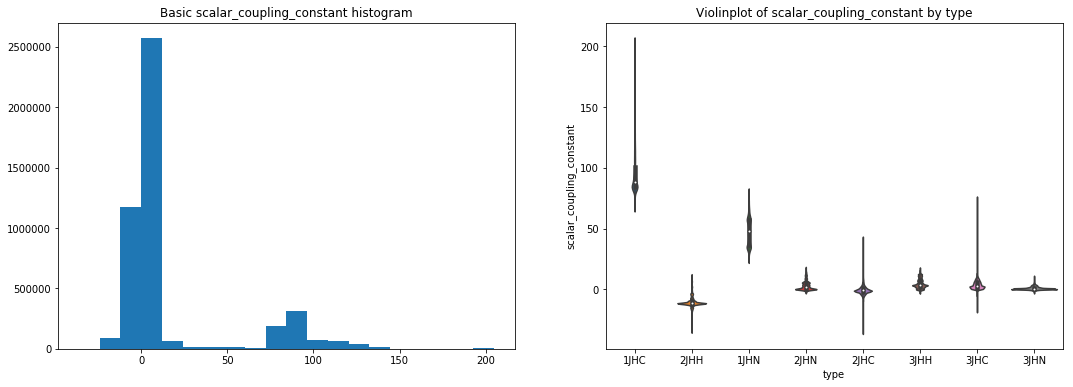

In [10]:
fig, ax = plt.subplots(figsize = (18, 6))
plt.subplot(1, 2, 1);
plt.hist(train['scalar_coupling_constant'], bins=20);
plt.title('Basic scalar_coupling_constant histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='scalar_coupling_constant', data=train);
plt.title('Violinplot of scalar_coupling_constant by type');

There are many interesting things here:
- among first atoms there is a little number of atoms with index lower than 7 or higher than 24;
- among second atoms there is a little number of atoms with index higher than 24. Also index with atom with index 9 in quite rare;
- coupling types are unevenly distributed. There are 3 very popular, 3 quite rare and 2 with medium frequency;
- target variable has a bimodal distribution;
- different coupling types have really different values of target variable. Maybe it would make sense to build separate models for each of them;

## Plotting network graphs by type

We have molecules, atom pairs, so this means data, which is interconnected. Network graphs should be useful to visualize such data!

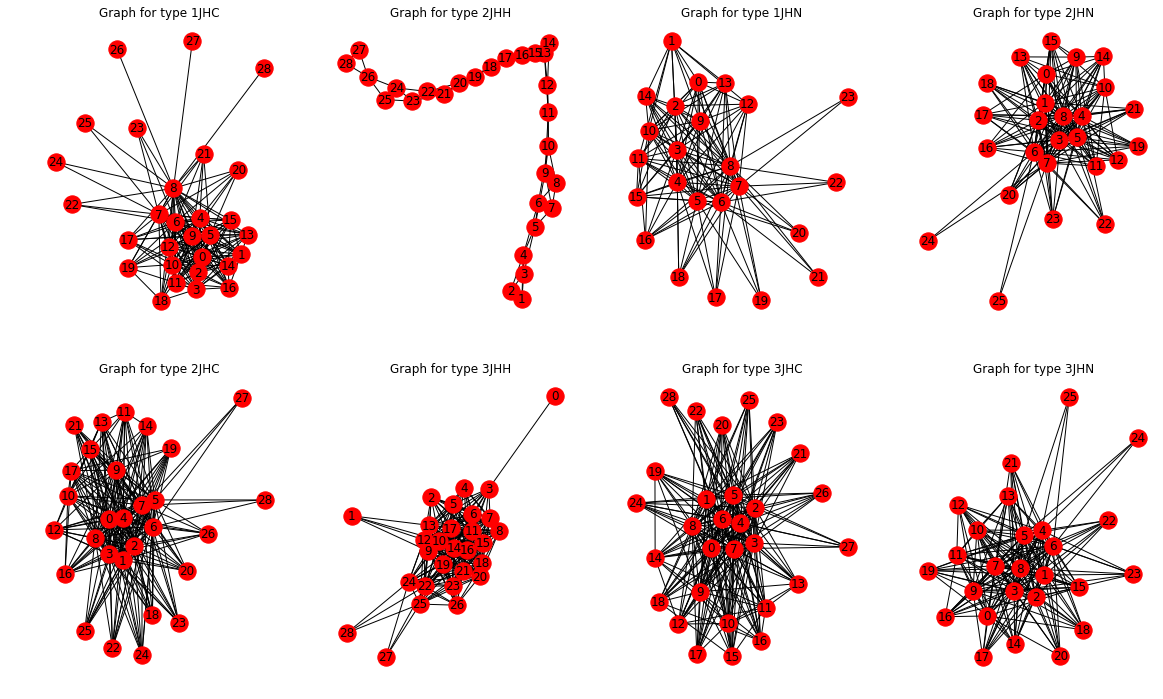

In [11]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Cool! We can see that atom connections have different shapes for different types. Type 2JHH has an expecially unique scheme.
Also we can see that some atoms are connected only to several other atoms.

## Better network graphs
But there is a little problem: as we saw earlier, there are atoms which are very rare, as a result graphs will be skewed due to them. Now I'll drop atoms for each type which are present in less then 1% of connections

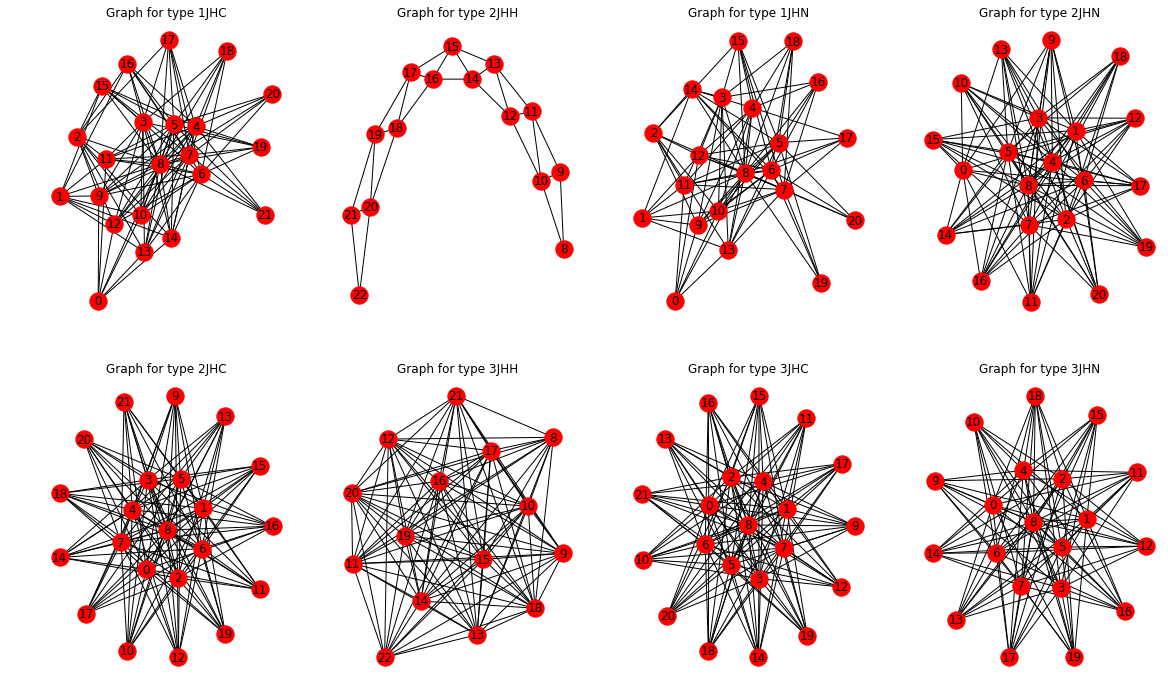

In [12]:
fig, ax = plt.subplots(figsize = (20, 12))
for i, t in enumerate(train['type'].unique()):
    train_type = train.loc[train['type'] == t]
    bad_atoms_0 = list(train_type['atom_index_0'].value_counts(normalize=True)[train_type['atom_index_0'].value_counts(normalize=True) < 0.01].index)
    bad_atoms_1 = list(train_type['atom_index_1'].value_counts(normalize=True)[train_type['atom_index_1'].value_counts(normalize=True) < 0.01].index)
    bad_atoms = list(set(bad_atoms_0 + bad_atoms_1))
    train_type = train_type.loc[(train_type['atom_index_0'].isin(bad_atoms_0) == False) & (train_type['atom_index_1'].isin(bad_atoms_1) == False)]
    G = nx.from_pandas_edgelist(train_type, 'atom_index_0', 'atom_index_1', ['scalar_coupling_constant'])
    plt.subplot(2, 4, i + 1);
    nx.draw(G, with_labels=True);
    plt.title(f'Graph for type {t}')

Now the graphs are much more clear!

## Feature engineering

For now I'll use a basic approach to feature engineering.

I'll use this useful kernel:
https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [13]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [14]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

I want to create two new features: one will show the first character of the `type`, the second one will show other characters.

In [15]:
train['type_0'] = train['type'].apply(lambda x: x[0])
test['type_0'] = test['type'].apply(lambda x: x[0])
train['type_1'] = train['type'].apply(lambda x: x[1:])
test['type_1'] = test['type'].apply(lambda x: x[1:])

So, everyone uses this distance feature, let's have a look at it!

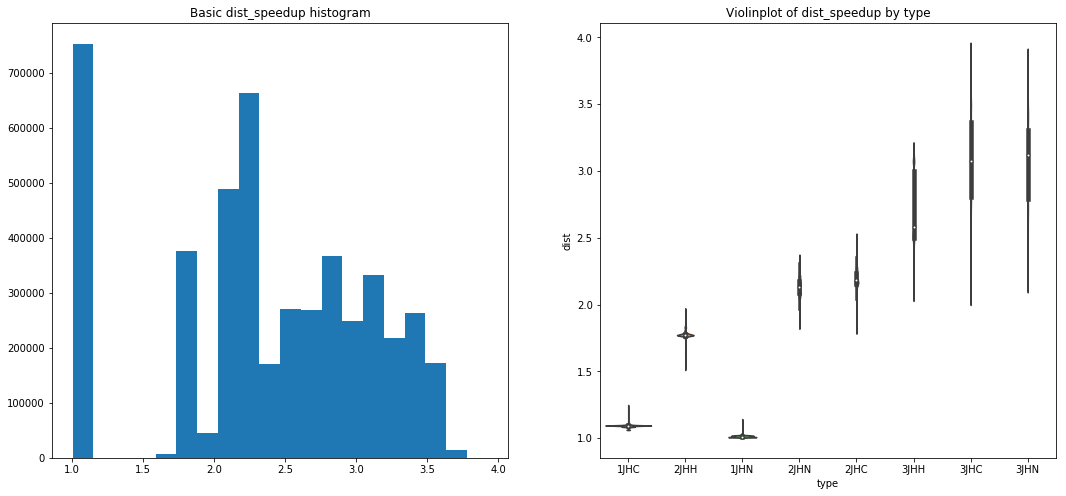

In [16]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1, 2, 1);
plt.hist(train['dist'], bins=20);
plt.title('Basic dist_speedup histogram');
plt.subplot(1, 2, 2);
sns.violinplot(x='type', y='dist', data=train);
plt.title('Violinplot of dist_speedup by type');

It seems that the values are quite different for different types!

In [17]:
train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')

train['dist_to_type_0_mean'] = train['dist'] / train.groupby('type_0')['dist'].transform('mean')
test['dist_to_type_0_mean'] = test['dist'] / test.groupby('type_0')['dist'].transform('mean')

train['dist_to_type_1_mean'] = train['dist'] / train.groupby('type_1')['dist'].transform('mean')
test['dist_to_type_1_mean'] = test['dist'] / test.groupby('type_1')['dist'].transform('mean')

In [18]:
train[f'molecule_type_dist_mean'] = train.groupby(['molecule_name', 'type'])['dist'].transform('mean')
test[f'molecule_type_dist_mean'] = test.groupby(['molecule_name', 'type'])['dist'].transform('mean')

## Basic model

I'll use the function for metric calculation from this kernel: https://www.kaggle.com/abhishek/competition-metric

UPD: use faster metric from this kernel: https://www.kaggle.com/uberkinder/efficient-metric

You can see the code in my utility script. Please note that to use this metric for calculation you need to pass value `group_mae` to parameter `eval_metric`.

In [19]:
for f in ['atom_0', 'atom_1', 'type_0', 'type_1', 'type']:
    lbl = LabelEncoder()
    lbl.fit(list(train[f].values) + list(test[f].values))
    train[f] = lbl.transform(list(train[f].values))
    test[f] = lbl.transform(list(test[f].values))

In [20]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_x,dist_y,dist_z,type_0,type_1,dist_to_type_mean,dist_to_type_0_mean,dist_to_type_1_mean,molecule_type_dist_mean
0,0,dsgdb9nsd_000001,1,0,0,84.807599999999994,0,0.002150416,-0.0060313176,0.0019761204,0,-0.0126981359,1.085804158,0.0080009958,1.091953059611900,0.000220479493527,1.192104705778678,0.000036299123586,0,0,0.999133993514757,1.003366595134415,0.463061408177816,1.091949649609598
1,1,dsgdb9nsd_000001,1,2,3,-11.257000000000000,0,0.002150416,-0.0060313176,0.0019761204,1,1.0117308430,1.463751162,0.0002765748,1.783119756038801,1.019252638581502,2.160260537339124,0.000002888455246,1,1,1.004633785679569,0.852949262177106,0.761935207514872,1.783146310703152
2,2,dsgdb9nsd_000001,1,3,3,-11.254799999999999,0,0.002150416,-0.0060313176,0.0019761204,1,-0.5408150690,1.447526614,-0.8766437152,1.783147496403011,0.294811517901285,2.112830660517270,0.771972815509771,1,1,1.004649414975929,0.852962531685845,0.761947061099068,1.783146310703152
3,3,dsgdb9nsd_000001,1,4,3,-11.254300000000001,0,0.002150416,-0.0060313176,0.0019761204,1,-0.5238136345,1.437932644,0.9063972942,1.783156685329616,0.276638182418367,2.085031922399566,0.817977659617770,1,1,1.004654592141451,0.852966927177590,0.761950987569333,1.783146310703152
4,4,dsgdb9nsd_000001,2,0,0,84.807400000000001,0,1.011730843,1.4637511620,0.0002765748,0,-0.0126981359,1.085804158,0.0080009958,1.091951618581363,1.049454732810097,0.142843937832576,0.000059666679785,0,0,0.999132674975848,1.003365271009819,0.463060797084121,1.091949649609598


In [21]:
X = train.drop(['id', 'molecule_name', 'scalar_coupling_constant'], axis=1)
y = train['scalar_coupling_constant']
X_test = test.drop(['id', 'molecule_name'], axis=1)

In [22]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Fri Jun 21 17:36:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.76127	valid_1's l1: 1.87648
[2000]	training's l1: 1.60561	valid_1's l1: 1.80243
[3000]	training's l1: 1.49835	valid_1's l1: 1.76327
[4000]	training's l1: 1.41313	valid_1's l1: 1.73724
[5000]	training's l1: 1.34121	valid_1's l1: 1.71898
[6000]	training's l1: 1.27872	valid_1's l1: 1.70493
[7000]	training's l1: 1.22194	valid_1's l1: 1.69276
[8000]	training's l1: 1.17166	valid_1's l1: 1.68333
[9000]	training's l1: 1.12495	valid_1's l1: 1.67474
[10000]	training's l1: 1.08203	valid_1's l1: 1.6672
Did not meet early stopping. Best iteration is:
[10000]	training's l1: 1.08203	valid_1's l1: 1.6672
Fold 2 started at Fri Jun 21 18:35:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's l1: 1.76014	valid_1's l1: 1.87743
[2000]	training's l1: 1.6056	valid_1's l1: 1.80467
[3000]	training's l1: 1.49884	valid_1's l1: 1.7664
[4000]	trainin

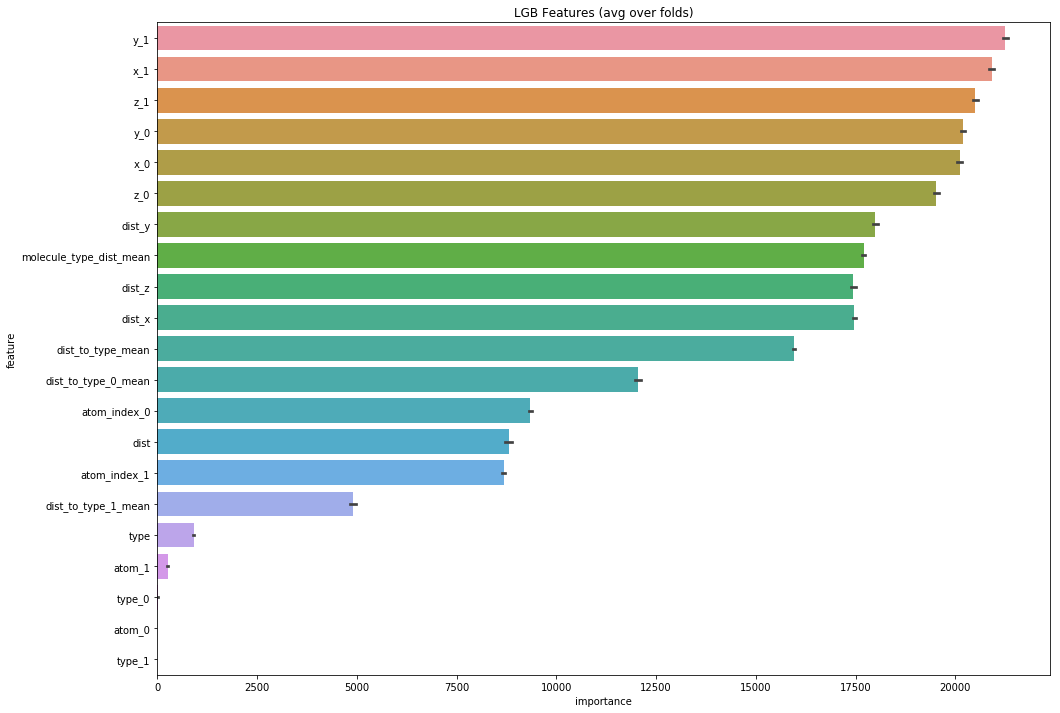

In [23]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 13,
          'learning_rate': 0.2,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='group_mae', plot_feature_importance=True,
                                                      verbose=1000, early_stopping_rounds=200, n_estimators=10000)


In [24]:
sub['scalar_coupling_constant'] = result_dict_lgb['prediction']
sub.to_csv('submission.csv', index=False)
sub.head()

,id,scalar_coupling_constant
0,4658147,6.134407309764244
1,4658148,197.177205914150449
2,4658149,2.955234119143113
3,4658150,195.252145987560709
4,4658151,5.836080715833913


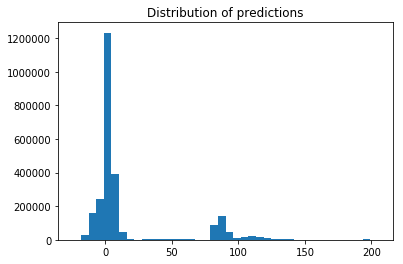

In [25]:
plt.hist(result_dict_lgb['prediction'], bins=40);
plt.title('Distribution of predictions');

## Plot oof predictions vs target

I use the code from benchmark kernel: https://www.kaggle.com/inversion/atomic-distance-benchmark

Notice that while using `LabelEncoder` on categorical variables, `type` was the last feature, so `lbl` contains encodings for it and we can inverse_transform `type`.

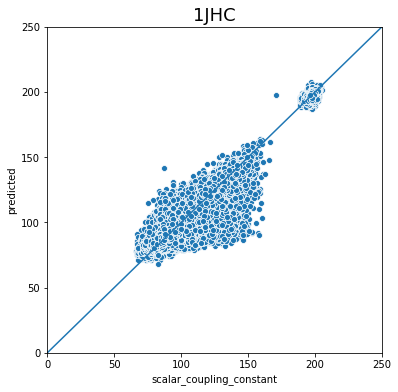

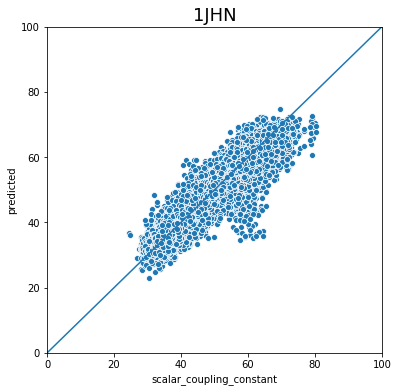

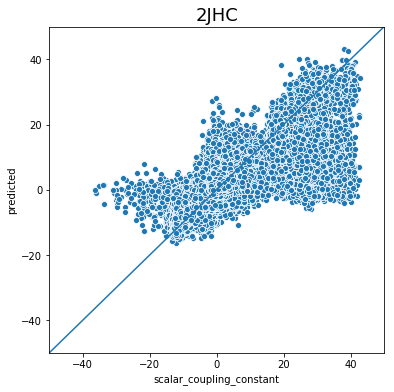

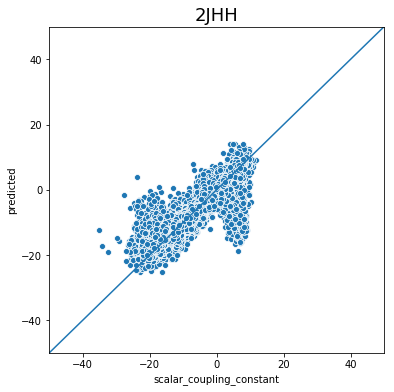

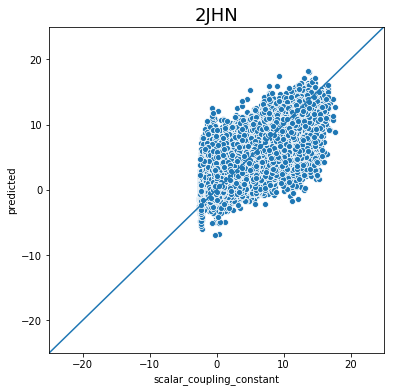

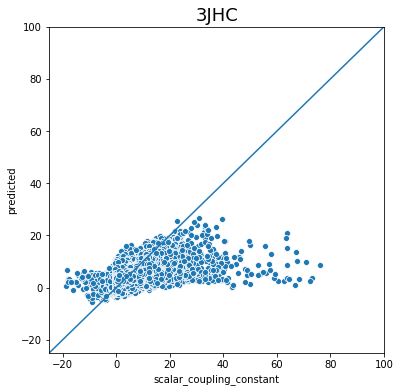

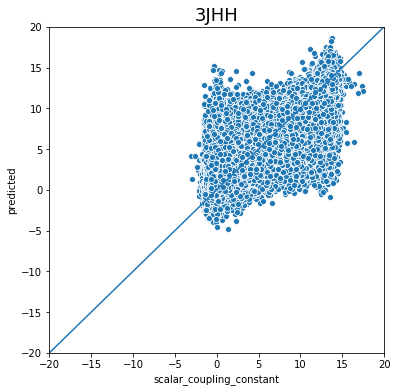

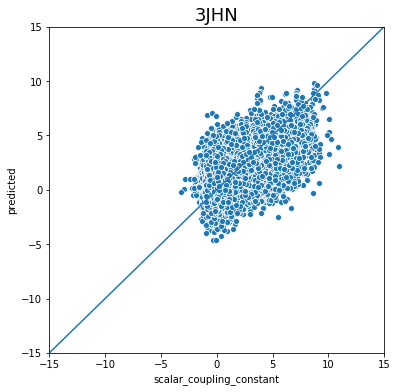

In [26]:
plot_data = pd.DataFrame(y)
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_lgb['oof']
plot_data['type'] = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)

We can see that some types has better predictions than others. Maybe we should focus on improving models for these types?